### Load the data and fix the schema

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
def Download():
    # Download the input file
    print('downloading the input files')
    import urllib.request
    urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx','online_retail_II.xlsx')
    urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx','online_retail.xlsx')

def ConvertCsv():
    # Download and covert the columns, etc
    print('downloading the data...')
    Download()
    print('Reading in the data...')
    df=pd.read_excel('online_retail_II.xlsx')
    df2=pd.read_excel('online_retail.xlsx')
    # make sure to harmonize the data columns
    df2.columns=['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','Price', 'Customer ID', 'Country']

    df3 = pd.concat([df,df2])
    df3.to_csv('online_combined.csv')
    
# reading xlxs is very slow, so we convert this to csv
print('')
print('Reading xlxs is very slow, so we convert this to csv')
if not os.path.exists('online_combined.csv'):
    ConvertCsv()


Reading xlxs is very slow, so we convert this to csv


### This code will go through the EDA and provide insights, which I put in the comments as well as the printout. Added total cost of each product to use for future analysis.

In [3]:
draw=True
verbose=False

df = pd.read_csv('online_combined.csv')
if verbose:
    print (df)
# Fix column type
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
if verbose:
    print (df.sort_values(by='InvoiceDate'))
#print the column names
if verbose:
    print(df.columns)

# add the total amount spent
df['totalcost'] = df['Price']*df['Quantity']

In [5]:
import seaborn as sns
sns.set_style('darkgrid')

### Check the data shape and data types. I don't see any obvious problems with the data types. no floats that should be objects, etc. Fixed these above already

In [10]:
print(df.shape)
print('')
print(df.dtypes)

(1067370, 10)

Unnamed: 0              int64
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
totalcost             float64
dtype: object


### Print some rows to get an idea of the data

In [14]:
print(df.head())
print(df.tail())
print(df.sample(5))

print('Summary of nan objects:')
df['nullID']=df['Customer ID'].isnull()
for c in df.columns:
    print('Column: %s and the number corrupted: %s' %(c, df[c].isnull().sum()))
    
# brief summary for future analysis. I wanted to know how many users IDs are missing
print('')
print('Brief summary for future analysis. I wanted to know how many users IDs are missing as well as how many customers, items, and invoices there are. ')
print('Unique purchases: %s' %(len(df['Description'].unique())))
print('Unique customers: %s' %(len(df['Customer ID'].unique())))
print('Unregistered purchases: %s' %(len(df[df['nullID']==True]['Invoice'].unique())))
print('Unique Invoices: %s' %(len(df['Invoice'].unique())))

   Unnamed: 0 Invoice StockCode                          Description  \
0           0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
1           1  489434    79323P                   PINK CHERRY LIGHTS   
2           2  489434    79323W                  WHITE CHERRY LIGHTS   
3           3  489434     22041         RECORD FRAME 7" SINGLE SIZE    
4           4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX   

   Quantity         InvoiceDate  Price  Customer ID         Country  totalcost  
0        12 2009-12-01 07:45:00   6.95      13085.0  United Kingdom       83.4  
1        12 2009-12-01 07:45:00   6.75      13085.0  United Kingdom       81.0  
2        12 2009-12-01 07:45:00   6.75      13085.0  United Kingdom       81.0  
3        48 2009-12-01 07:45:00   2.10      13085.0  United Kingdom      100.8  
4        24 2009-12-01 07:45:00   1.25      13085.0  United Kingdom       30.0  
         Unnamed: 0 Invoice StockCode                      Description  \
1067365

### Draw all of the distributions. Looking for extrema. I see some extreme order sizes "Quantity" and some extreme prices. I'm surprised that some prices are negative and some that some are very large
#### I read off that there is a large increase in items ordered near the winter holidays. Might be worthwhile to hire more staff during that period of time.

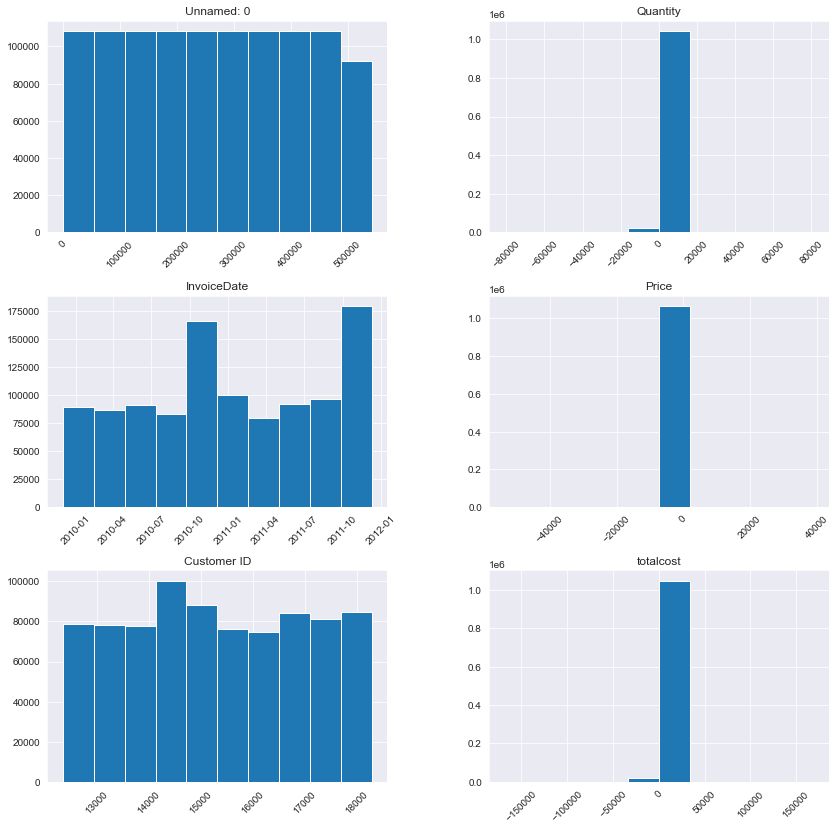

In [17]:
df.hist(figsize=(14,14), xrot=45)
plt.show()

### Let's print some rows to see why the price is large and/or negative
#### The negative prices are from bad debt. I think this is balancing books. I'm not sure that these are useful for customer profiles. The Customer IDs are Nan, so i'd just remove these for the customer based analysis. Longer term I would ask where this is coming from. The bad debt is 11k to 54k pounds.

In [21]:
print(df[df['Price']<-1.0])
df = df[df['Price']>-0.1]

        Unnamed: 0  Invoice StockCode      Description  Quantity  \
179403      179403  A506401         B  Adjust bad debt         1   
276274      276274  A516228         B  Adjust bad debt         1   
403472      403472  A528059         B  Adjust bad debt         1   
825444      299983  A563186         B  Adjust bad debt         1   
825445      299984  A563187         B  Adjust bad debt         1   

               InvoiceDate     Price  Customer ID         Country  totalcost  \
179403 2010-04-29 13:36:00 -53594.36          NaN  United Kingdom  -53594.36   
276274 2010-07-19 11:24:00 -44031.79          NaN  United Kingdom  -44031.79   
403472 2010-10-20 12:04:00 -38925.87          NaN  United Kingdom  -38925.87   
825444 2011-08-12 14:51:00 -11062.06          NaN  United Kingdom  -11062.06   
825445 2011-08-12 14:52:00 -11062.06          NaN  United Kingdom  -11062.06   

        nullID  
179403    True  
276274    True  
403472    True  
825444    True  
825445    True  


### let's see what some of the negative totalcost is. totalcost = price times quantity
#### There are around 18k cancellations. Let's focus on the extreme cancellations
#### Let's see what the most extreme cancellations are caused by? The largest is more than 80k units
#### The two biggest cancellations seem to be mistakes. The customers did not have large orders before, and they cancelled their items within 20minutes. Maybe the website needs to be improved? Could reach out to these customers. The large cancellation seems to be the end of the their transactions, so it might help to avoid losing customers.

In [35]:
print(df[df['totalcost']<-1.0])
print('large cancellations with more than 500 pounds')
print(df[df['totalcost']<-500.0].describe())
print(df[df['totalcost']<-70000.0])
# checking these customers with large cancellations
print('')
print('Checking Customer ID 12346')
print(df[df['Customer ID']==12346.0])
print('')
print('Checking Customer ID 16446')
print(df[df['Customer ID']==16446.0])


         Unnamed: 0  Invoice StockCode                       Description  \
178             178  C489449     22087          PAPER BUNTING WHITE LACE   
179             179  C489449    85206A      CREAM FELT EASTER EGG BASKET   
180             180  C489449     21895     POTTING SHED SOW 'N' GROW SET   
181             181  C489449     21896                POTTING SHED TWINE   
182             182  C489449     22083        PAPER CHAIN KIT RETRO SPOT   
...             ...      ...       ...                               ...   
1065910      540449  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL   
1067002      541541  C581499         M                            Manual   
1067176      541715  C581568     21258        VICTORIAN SEWING BOX LARGE   
1067177      541716  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER   
1067178      541717  C581569     20979     36 PENCILS TUBE RED RETROSPOT   

         Quantity         InvoiceDate   Price  Customer ID         Country  \
178      

### Given the above, let's remove some of these extreme cancellations

In [43]:
df = df[df['Invoice']!='581483']
df = df[df['Invoice']!='C581484']
df = df[df['Invoice']!='541431']
df = df[df['Invoice']!='C541433']


### Let's see how things look now
#### Could clean more of the returns, but let's move forward. It does not look like the most extreme returns are returning all items, but certainly understanding this more would be useful long term. we want to keep customers happy, especially those making the biggest orders

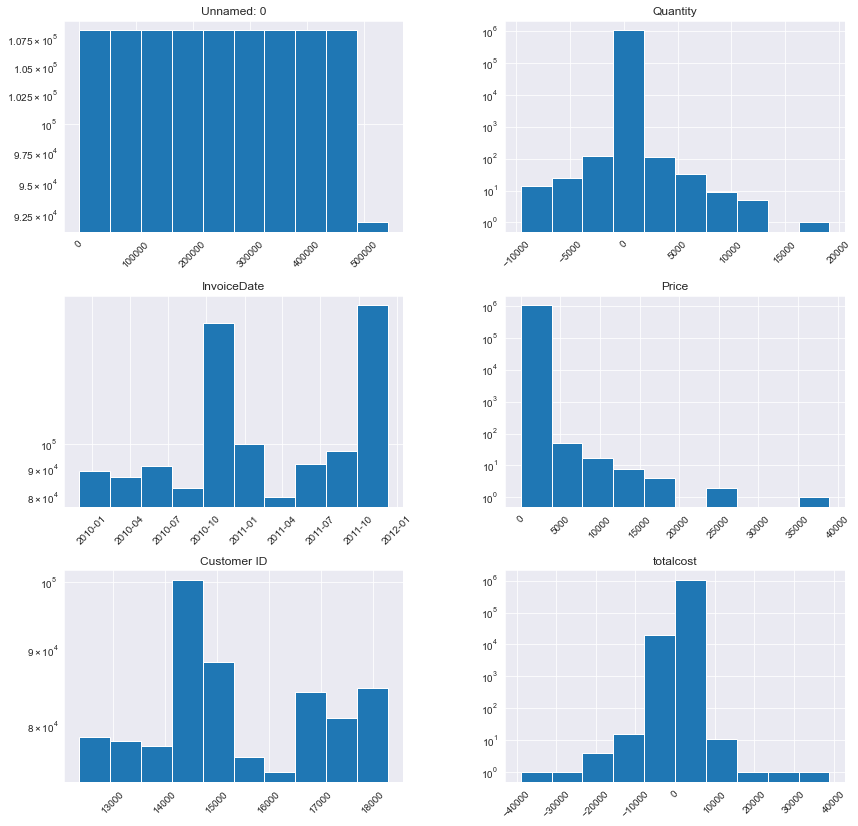

In [45]:
df.hist(figsize=(14,14), xrot=45, log=True)
plt.show()

In [40]:
print(df[df['Quantity']<-500])

         Unnamed: 0  Invoice StockCode                  Description  Quantity  \
3162           3162   489660     35956                         lost     -1043   
4296           4296   489806     18010                          NaN      -770   
4538           4538   489820     21133              invcd as 84879?      -720   
6556           6556   489899   79323GR                 sold as gold      -954   
6911           6911   490007     84347                        21494      -720   
...             ...      ...       ...                          ...       ...   
1021312      495851   578328    72807B                   wet pallet      -696   
1040196      514735   579742     85204                       lost??     -1131   
1047624      522163   580382     16045                        check      -900   
1060796      535335   581212     22578                         lost     -1050   
1065883      540422  C581484     23843  PAPER CRAFT , LITTLE BIRDIE    -80995   

                InvoiceDate

In [46]:
df.describe()

,Unnamed: 0,Quantity,Price,Customer ID,totalcost
count,1.067361e+06,1.067361e+06,1.067361e+06,824359.000000,1.067361e+06
mean,2.669051e+05,9.938986e+00,4.798071e+00,15324.646218,1.821868e+01
std,1.541712e+05,8.493917e+01,9.543415e+01,1697.459860,1.224916e+02
min,0.000000e+00,-9.600000e+03,0.000000e+00,12346.000000,-3.897000e+04
25%,1.334210e+05,1.000000e+00,1.250000e+00,13975.000000,3.750000e+00
50%,2.668410e+05,3.000000e+00,2.100000e+00,15255.000000,9.900000e+00
75%,4.002630e+05,1.000000e+01,4.150000e+00,16797.000000,1.770000e+01
max,5.419080e+05,1.915200e+04,3.897000e+04,18287.000000,3.897000e+04


### Check the distributions
#### There are too many different objects being sold, so it is probably not worth categorizing them at this time
#### Countries in which the customer ordered is primarily the UK. If the company wants to branch out of the UK, then the next biggest markets to target are EIRE, Netherlands, Germany, and France would be the best places to start advertising

Invoice
StockCode
Description
Country


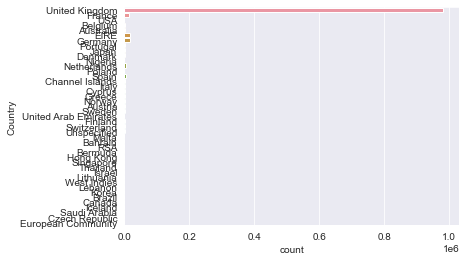

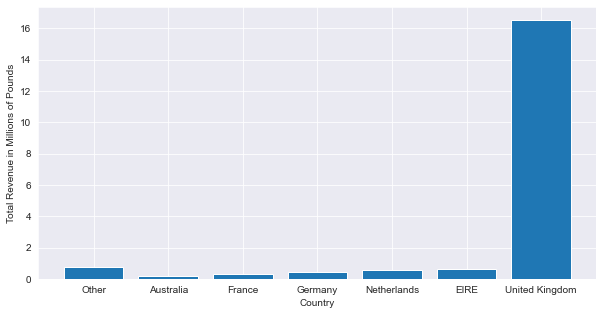

In [55]:
for column in df.select_dtypes(include='object'):
    print(column)
    if df[column].nunique() < 100:
        sns.countplot(y=column, data=df)
        plt.show()
        
        
orders_by_country = df.groupby(['Country'], dropna=True).sum().sort_values(by='totalcost')[-6:]
orders_by_country_other = df.groupby(['Country'], dropna=True).sum().sort_values(by='totalcost')[:-7]['totalcost'].sum()
if verbose:
    print(orders_by_country)
if True:
    fig = plt.figure(figsize = (10, 5))
    plt.bar( list(['Other'])+list(orders_by_country.index),list(list([orders_by_country_other/1.0e6])+list(orders_by_country['totalcost']/1.0e6)))
    plt.xlabel('Country')
    plt.ylabel('Total Revenue in Millions of Pounds')
    plt.show()
    #print('Total Revenue from >100 orders: %s' %((rev['>500']+rev['100-499'])/sum(rev.values())))
   

### Curious how the total sales are broken down versus country, which looks like the only sensible way to split the orders
#### Nothing too surprising. Most of the big orders are from the UK and same with the cancellations
#### a few big orders came from Norway, which might be interesting to understand why they were cancelled. 

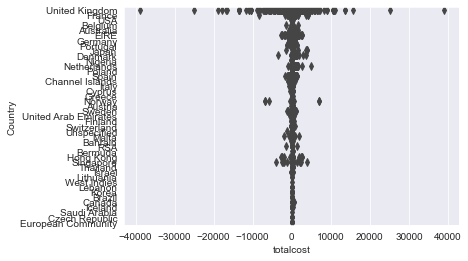

In [59]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 100:
        sns.boxplot(y=column, x='totalcost', data=df)
        plt.show()

#### Quickly checking these big orders from Norway. All coming from the same customer. printing their history. A lot of the descriptions say manual, which makes me think that this Customer interacted with staff. This might be a useful case to improve customer relations or descriptions online to improve the customer experience
#### I don't see anything very interesting here. I'd probably discuss this with as a possible case to improve customer interactions. This customer ordered and cancelled the same items several times within a 23 minute period. Then never tried to order again. Seems like an opportunity to learn more to keep from losing first time customers

In [67]:
norway = df[df['Country']=='Norway']

print(norway[norway['totalcost']<-5000])
print(norway[norway['totalcost']>5000])
print(df[df['Customer ID']==15760.0])

        Unnamed: 0  Invoice StockCode Description  Quantity  \
129902      129902  C501751         M      Manual        -1   
129988      129988  C501769         M      Manual        -1   
130003      130003  C501771         M      Manual        -1   

               InvoiceDate    Price  Customer ID Country  totalcost  nullID  
129902 2010-03-19 11:30:00  6958.17      15760.0  Norway   -6958.17   False  
129988 2010-03-19 11:49:00  6958.17      15760.0  Norway   -6958.17   False  
130003 2010-03-19 11:53:00  5795.87      15760.0  Norway   -5795.87   False  
        Unnamed: 0 Invoice StockCode Description  Quantity  \
129903      129903  501766         M      Manual         1   
129987      129987  501768         M      Manual         1   

               InvoiceDate    Price  Customer ID Country  totalcost  nullID  
129903 2010-03-19 11:35:00  6958.17      15760.0  Norway    6958.17   False  
129987 2010-03-19 11:45:00  6958.17      15760.0  Norway    6958.17   False  
        Unname

### Print the correlations. For this dataset, the correlations are not very interesting. I think most of the analysis would be in text analytics on the items that people are buying. The most correlated is cost and Quantity. I think the dataset is fairly clean at this point with some caveats on orders and cancellations. Likely the cancellations should be removed a bit better.

             Unnamed: 0  Quantity     Price  Customer ID  totalcost    nullID
Unnamed: 0     1.000000 -0.004033 -0.002127     0.010678  -0.000332 -0.054790
Quantity      -0.004033  1.000000 -0.003635    -0.012794   0.212610 -0.053683
Price         -0.002127 -0.003635  1.000000    -0.003835  -0.338314  0.021640
Customer ID    0.010678 -0.012794 -0.003835     1.000000  -0.008806       NaN
totalcost     -0.000332  0.212610 -0.338314    -0.008806   1.000000 -0.029723
nullID        -0.054790 -0.053683  0.021640          NaN  -0.029723  1.000000


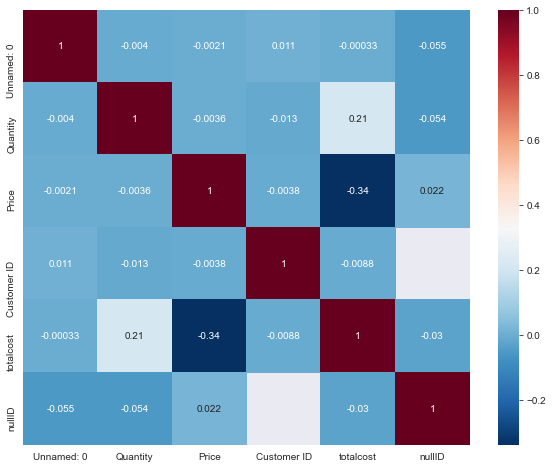

In [71]:
corrs = df.corr()
print(corrs)

plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

#### Can we remove the cancellations more cleanly. Let's drop the Nan customers. Most of these This is a bit of hack just to get some useful info. Let's remove the Nan customers. Some of these seem to be amazon fees and other things. If we want a customer profile, then I think we should remove these. This of course misses customers that did not register, but these are a relative small number (e.g. less than 21% of all lines)

In [91]:
#nancustomers = df[df['Customer ID'].isna()]
#nancustomers[nancustomers['totalcost']<-5.0]
#nancustomers[nancustomers['Customer ID']=='AMAZONFEE']
dfrmNanCustomers = df[df['Customer ID'].notna()]
#[df['totalcost']<-500]

In [92]:
print(dfrmNanCustomers)

         Unnamed: 0 Invoice StockCode                          Description  \
0                 0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
1                 1  489434    79323P                   PINK CHERRY LIGHTS   
2                 2  489434    79323W                  WHITE CHERRY LIGHTS   
3                 3  489434     22041         RECORD FRAME 7" SINGLE SIZE    
4                 4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX   
...             ...     ...       ...                                  ...   
1067365      541904  581587     22613          PACK OF 20 SPACEBOY NAPKINS   
1067366      541905  581587     22899         CHILDREN'S APRON DOLLY GIRL    
1067367      541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
1067368      541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
1067369      541908  581587     22138        BAKING SET 9 PIECE RETROSPOT    

         Quantity         InvoiceDate  Price  Customer ID      

### Checking the summary plots one more time.

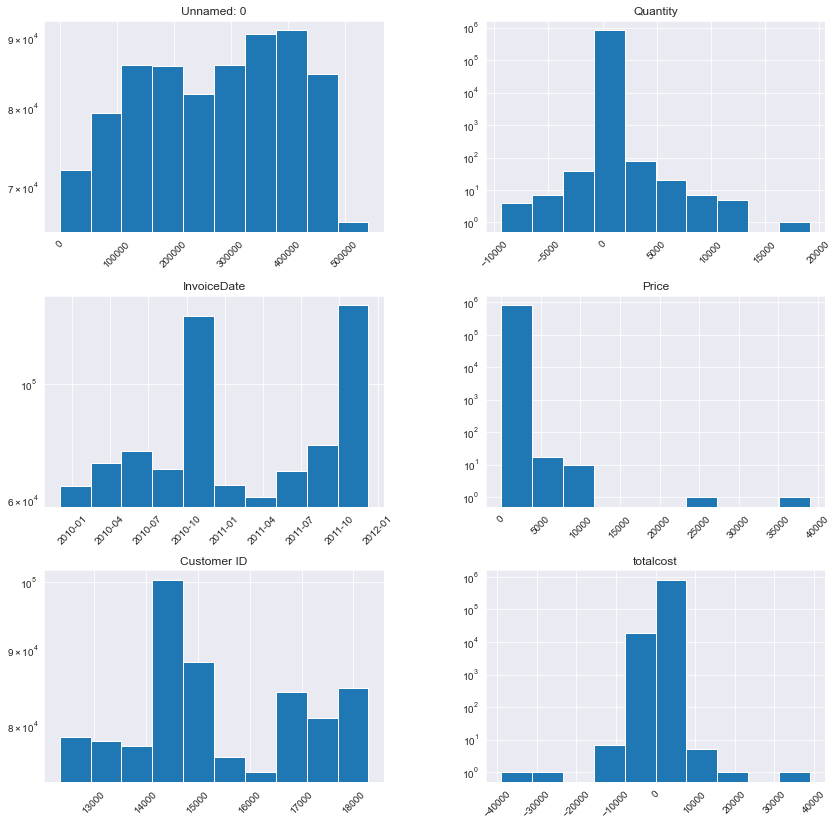

In [93]:
dfrmNanCustomers.hist(figsize=(14,14), xrot=45, log=True)
plt.show()